In [64]:
import numpy
import qiskit
from qiskit import Aer
import qiskit.providers.aer.noise as noise
from qiskit.opflow import I,X,Y,Z
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit import QuantumCircuit,execute,QuantumRegister,ClassicalRegister
from openfermion.linalg import givens_decomposition_square as givensRotns 

In [65]:
num_qubits=2

# Hamiltonian 
\begin{align}
H=J_{XY} (XX+YY) +J_{Z} ZZ
\end{align}

In [134]:
def H(J1,J2,h):
    H_op=(J1*(X^X))+(J1*(Y^Y))+(J2*(Z^Z))
    H_XY=H_op[0:2]
    H_ZZ=H_op[2:]
    return H_op,H_XY,H_ZZ

In [135]:
 #Prepare UnitaryOp for rotating Hamilotnian terms
def U(theta):    
    O_0=(numpy.cos(theta/2.)*I^I)+(1j*numpy.sin(theta/2.)*X^Y)
    O_1=(numpy.cos(theta/2.)*I^I)+(-1j*numpy.sin(theta/2.)*Y^X)
    O=O_0@O_1
    return O                               

In [136]:
def rotated_XY_terms(H_XY):
    theta=numpy.pi/4
    #Prepare UnitaryOp for rotating Hamilotnian terms
    O_0=(numpy.cos(theta/2.)*I^I)+(-1j*numpy.sin(theta/2.)*X^Y)
    O_1=(numpy.cos(theta/2.)*I^I)+(+1j*numpy.sin(theta/2.)*Y^X)
    O=O_0@O_1
    rotH=O@H_XY@O.adjoint()
    rotH=rotH.reduce().reduce()
    #Prepare gate implementing Givens Rotn for appending to ansatz circ pre-measurement
    RotMat=(1/numpy.sqrt(2))*numpy.array([[1,-1],[1,1]])
    w,v=numpy.linalg.eigh(RotMat)
    givens=givensRotns(v.T)[0]
    circ=QuantumCircuit(2)
    for rots in givens:
        for tup in rots:
            circ.cnot(tup[1],tup[0])
            circ.cry(-2*tup[2],tup[0], tup[1])
            circ.cnot(tup[1], tup[0])
            circ.rz(tup[3],tup[1])        
    circ0_1gate=circ.to_instruction()
    return circ0_1gate,rotH

In [137]:
def NoiseModel(prob1=0.1,noisy_channels=[0,1,2,4]):
    # Error probabilities
    #prob_1 - 1-qubit gate
    error1 =noise.errors.pauli_error([('X',prob1), ('I', 1 - prob1)])
    print("one qubit errors")
    print(error1)
    # Add single qubit bit-flip errors to noise model
    noise_model = noise.NoiseModel()
    #noisy channels
    for i in range(len(noisy_channels)):
        noise_model.add_quantum_error(error1,['u1', 'u2', 'u3'],[noisy_channels[i]])
    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    return noise_model,basis_gates

In [165]:
def Energy_sv(circ):
    state=execute(circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()
    H_mat=H_op.to_matrix()
    E=state@H_mat@numpy.conjugate(state)
    return E

In [155]:
def noisy_Energy_estimate(circ):
    def estimate(PauliOp,counts):
        PauliString,coeff=PauliOp.primitive.to_list()[0]
        indexOfZs=numpy.where(numpy.array(list(PauliString))=='Z')[0]
        bitstrings,cnts=list(counts. keys()),list(counts.values())
        p=0
        for i in range(len(bitstrings)):
            counter_1=list(numpy.array(list(bitstrings[i]))[indexOfZs]).count('1')
            if counter_1%2==1:
                p=p+cnts[i]
        p=p/sum(cnts)
        mean=(1-2*p)
        return mean*coeff.real
    def meanOp(PauliOp,counts):
        mean=0
        for i in range(len(PauliOp)):
            mean=mean+estimate(PauliOp[i],counts)
        return mean 
    circ_arr=[circ.copy(),circ.copy()]
    circ_arr[0].append(circ0_1gate,[0,1])
    circ_arr[0].add_register(ClassicalRegister(2,'c'))
    circ_arr[1].add_register(ClassicalRegister(2,'c'))
    circ_arr[0].measure([0,1],[0,1])
    circ_arr[1].measure([0,1],[0,1])
    counts_arr=[]
    for i in range(len(circ_arr)):
        circ=qiskit.transpile(circ_arr[i],basis_gates=['cx', 'id', 'u1', 'u2', 'u3'])
        counts=execute(circ_arr[i],Aer.get_backend('qasm_simulator'),optimization_level=0,noise_model=noise_model,shots=2**14,had_transpiled=True).result().get_counts()
        counts_arr.append(counts)
    #print(counts_arr)    
    m1=meanOp(rotH,counts_arr[0])
    m2=meanOp(H_ZZ,counts_arr[1])
    return m1+m2,circ_arr

## 3 qubit repitition code $|0\rangle\rightarrow |000\rangle$, $|1\rangle\rightarrow |111\rangle$, 6 net qubits encode two logical qubits.

In [156]:
def error_corrected_energy_estimate(circ):
    dr=QuantumRegister(num_qubits,'data_qubit')
    cr=QuantumRegister(2*num_qubits,'code_qubit')
    def circuit_encoder(circ):
        #encoding two logical qubits in total 6 qubits.
        circ1=circ.copy()
        circ1.add_register(cr)
        circ1.barrier()
        for i in range(num_qubits):
            circ1.cx(dr[i],cr[2*i])
            circ1.cx(cr[2*i],cr[2*i+1]) 
        #passing the circuit over a noisy channel    
        circ1.u3(numpy.pi,-numpy.pi/2,numpy.pi/2,[0])
        circ1.u3(numpy.pi,-numpy.pi/2,numpy.pi/2,[1])
        circ1.u3(numpy.pi,-numpy.pi/2,numpy.pi/2,[2])
        circ1.u3(numpy.pi,-numpy.pi/2,numpy.pi/2,[3])
        circ1.u3(numpy.pi,-numpy.pi/2,numpy.pi/2,[4])
        circ1.u3(numpy.pi,-numpy.pi/2,numpy.pi/2,[5])
        return circ1 
    def addSyndromeCircuit(circ):
        #entangling syndrome/line qubits with the code qubits.
        circ1=circ.copy()
        lr=QuantumRegister(2*num_qubits,'line_qubit')
        qc=QuantumCircuit(lr)
        circ1=circ1+qc
        circ1.barrier()
        for i in range(num_qubits):
            circ1.cx(dr[i],lr[2*i])
            circ1.cx(cr[2*i],lr[2*i+1])
            circ1.cx(cr[2*i],lr[2*i])
            circ1.cx(cr[2*i+1],lr[2*i+1])
        circ1.barrier()
        #measuring syndrome qubits
        c_reg=ClassicalRegister(2*num_qubits,'line_qubits-measure')    
        circ1.add_register(c_reg)
        #for i in range(num_qubits):
        circ1.measure(lr,c_reg)
        circ1.barrier()
        #measuring code qubits
        c=ClassicalRegister(3*num_qubits,'code_qubits-measure')
        circ1.add_register(c)
        circ1.measure([0,2,3,1,4,5],c)
        return circ1
    def executor(state_circ):
        circ_arr=[state_circ.copy(),state_circ.copy()]
        circ_arr[0].append(circ0_1gate,[0,1])
        circ_arr[0]=qiskit.transpile(circ_arr[0],basis_gates=['cx', 'id', 'rx','ry','rz'])
        counts_arr=[]
        new_circ_arr=[]
        for i in range(len(circ_arr)):
            enc_circ=circuit_encoder(circ_arr[i])
            syn_circ=addSyndromeCircuit(enc_circ)
            new_circ_arr.append(syn_circ)
            circ=qiskit.transpile(syn_circ,basis_gates=['cx', 'id', 'u1', 'u2', 'u3'])
            counts=execute(syn_circ,Aer.get_backend('qasm_simulator'),optimization_level=0,noise_model=noise_model,shots=2**14).result().get_counts()
            counts_arr.append(counts) 
        return counts_arr,new_circ_arr
    def Decoding(res):
        #III: 00 (no error)
        #XII: 10 (error on 3rd qubit)
        #IXI: 11 (error on 2nd qubit)
        #IIX: 01 (error on 1st qubit)
        errDict={'10':0,'01':2,'11':1}
        def splitter(bit_str):
            arr=bit_str.split(' ')
            splitted=[arr[0][0:3],arr[0][3:],arr[1][0:2],arr[1][2:]]
            return splitted
        def modify(s):
            if s=='0':
                return '1'
            else:
                return '0'
        def editor(bit_str):
            splitted_str=splitter(bit_str)
            list_str=list(splitted_str[0])
            if splitted_str[2]!='00':
                list_str[errDict[splitted_str[2]]]=modify(list_str[errDict[splitted_str[2]]])
            list_str2=list(splitted_str[1])
            if splitted_str[3]!='00':
                list_str2[errDict[splitted_str[3]]]=modify(list_str2[errDict[splitted_str[3]]])
            new_corrected_string=''.join(list_str)+''.join(list_str2)
            return new_corrected_string
        newDict_arr=[]
        for i in range(len(res)):
            newDict={'10':0,'01':0,'11':0, '00':0}
            result=res[i]
            Keys=list(result.keys())
            for j in range(len(Keys)):
                if editor(Keys[j])=='111000':
                    newDict['01']=newDict['01']+result[Keys[j]]
                elif editor(Keys[j])=='000111':
                    newDict['10']=newDict['10']+result[Keys[j]]
                elif editor(Keys[j])=='111111':
                    newDict['00']=newDict['00']+result[Keys[j]]
                elif editor(Keys[j])=='000000':
                    newDict['11']=newDict['11']+result[Keys[j]]
            newDict_arr.append(newDict)            
        return newDict_arr
    def estimate(PauliOp,counts):
        PauliString,coeff=PauliOp.primitive.to_list()[0]
        indexOfZs=numpy.where(numpy.array(list(PauliString))=='Z')[0]
        bitstrings,cnts=list(counts. keys()),list(counts.values())
        p=0
        for i in range(len(bitstrings)):
            counter_1=list(numpy.array(list(bitstrings[i]))[indexOfZs]).count('1')
            if counter_1%2==1:
                p=p+cnts[i]
        p=p/sum(cnts)
        mean=(1-2*p)
        return mean*coeff.real
    def meanOp(PauliOp,counts):
        mean=0
        for i in range(len(PauliOp)):
            mean=mean+estimate(PauliOp[i],counts)
        return mean 
    res,exc_circs=executor(circ)
    new_res=Decoding(res)
    #print(new_res)
    m1=meanOp(rotH,new_res[0])
    m2=meanOp(H_ZZ,new_res[1])
    m=m1+m2
    return m,exc_circs

In [157]:
#ansatz circuit
def state_preparation(sym='s'):
    if sym=='s':
        dr=QuantumRegister(num_qubits,'data_qubit')
        Ansatz_circ=QuantumCircuit(dr)
        Ansatz_circ.x(0)
        Ansatz_circ.x(1)
        Ansatz_circ.h(0)
        Ansatz_circ.cx(0,1)
        return Ansatz_circ
    elif sym=='t':
        dr=QuantumRegister(num_qubits,'data_qubit')
        Ansatz_circ=QuantumCircuit(dr)
        #Ansatz_circ.x(0)
        Ansatz_circ.x(1)
        Ansatz_circ.h(0)
        Ansatz_circ.cx(0,1)
        return Ansatz_circ

## Bit flip Noise Model with a specified no. of noisy channels

In [158]:
noise_model,basis_gates=NoiseModel(prob1=0.07,noisy_channels=[0,1,2,4])
print(noise_model)

one qubit errors
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.07, QasmQobjInstructions = [[{'name': 'x', 'qubits': [0]}]
  P(1) = 0.9299999999999999, QasmQobjInstructions = [[{'name': 'id', 'qubits': [0]}]
NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u1', 'u2']
  Qubits with noise: [0, 1, 2, 4]
  Specific qubit errors: [('u1', [0]), ('u1', [1]), ('u1', [2]), ('u1', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [4])]


# measurement circuits for energy estimation-noisy estimate<br>
### measuring the XY terms of the two spin Hamiltonian

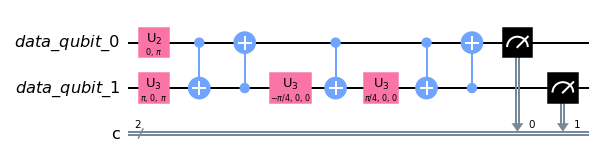

In [159]:
#circuits without error mitigation this 
circuits=noisy_Energy_estimate(state_circ)[1]
circ=qiskit.transpile(circuits[0],basis_gates=['id','cx','u1','u2','u3'])
circ.draw('mpl')

### measuring the ZZ terms of the two spin Hamiltonian

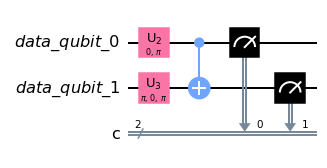

In [160]:
circ=qiskit.transpile(circuits[1],basis_gates=['id','cx','u1','u2','u3'])
circ.draw('mpl')

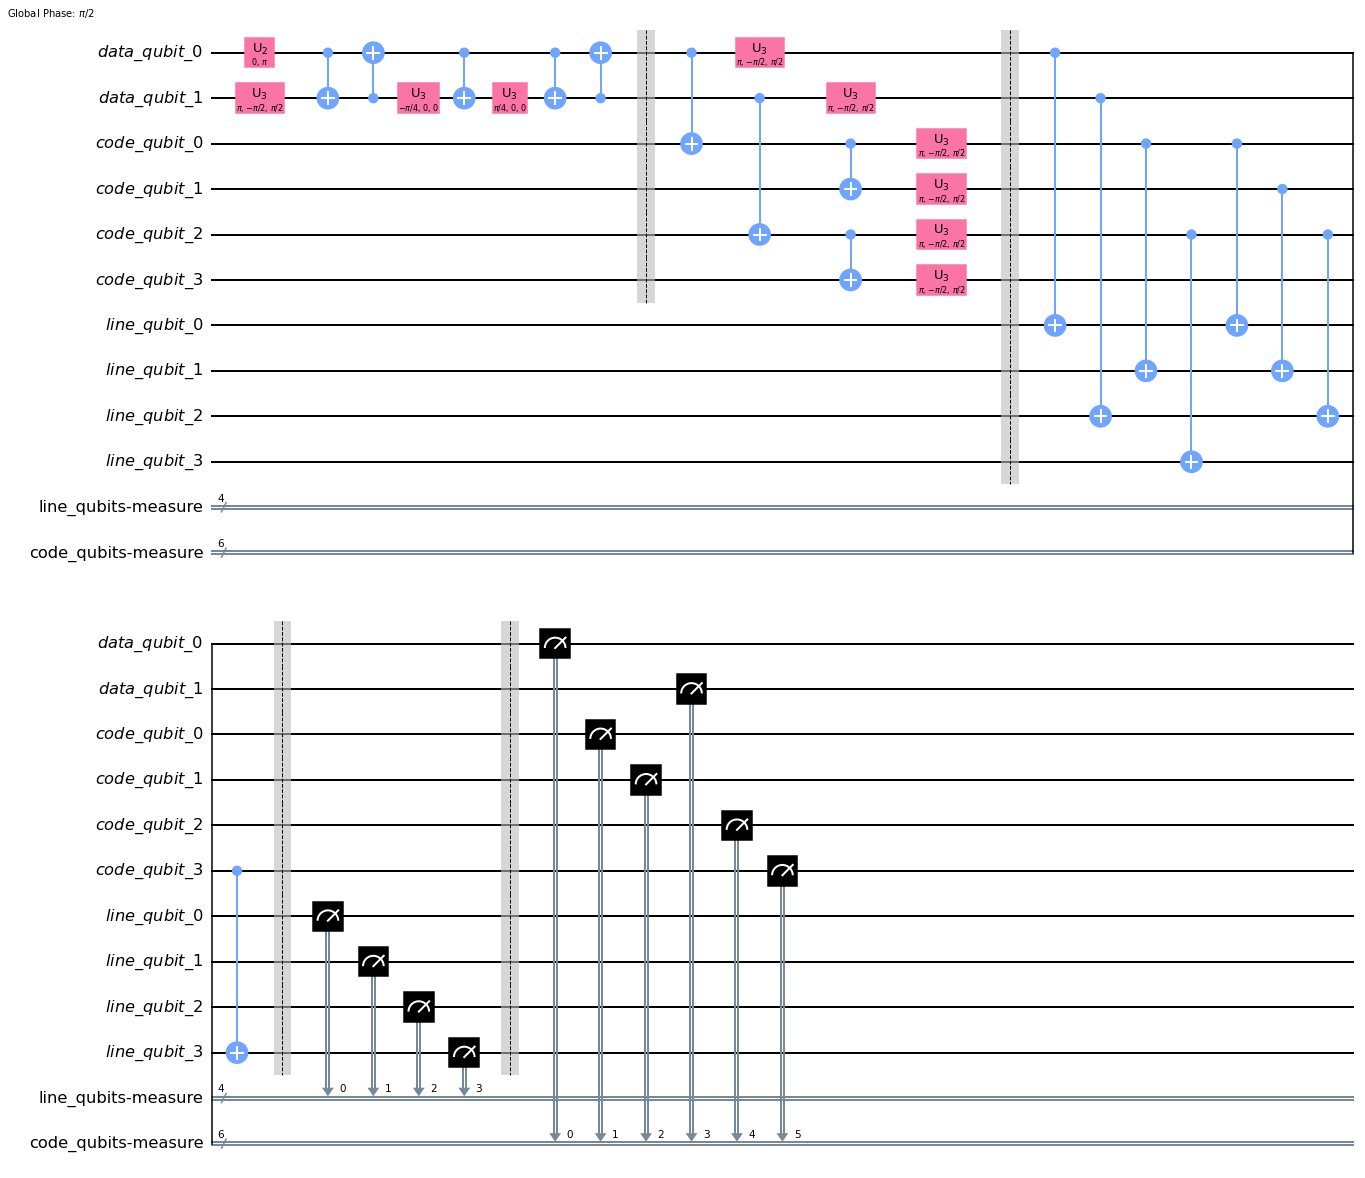

In [162]:
circuits=error_corrected_energy_estimate(state_circ)[1]
circ=qiskit.transpile(circuits[0],basis_gates=['id','cx','u1','u2','u3'])
circ.draw('mpl')

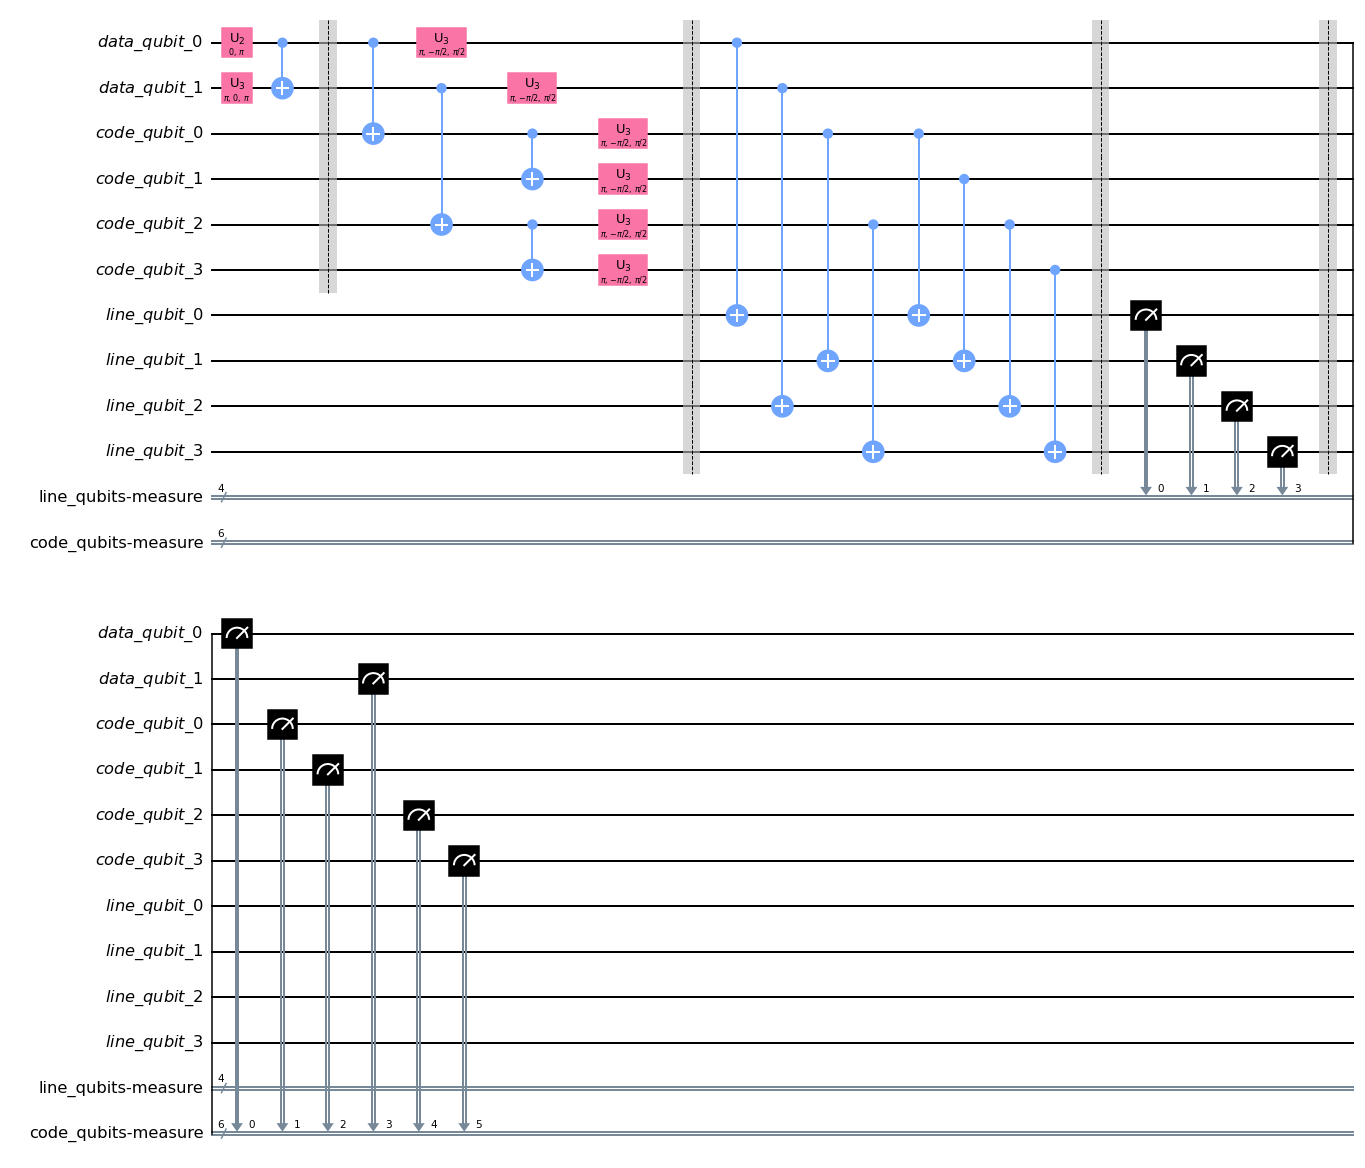

In [163]:
circ=qiskit.transpile(circuits[1],basis_gates=['id','cx','u1','u2','u3'])
circ.draw('mpl')

In [166]:
JzArr=[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]
Es_exact_Arr=[]
Es_noisy_Arr=[]
Es_mitig_Arr=[]
Es_exact_Arr1=[]
Es_noisy_Arr1=[]
Es_mitig_Arr1=[]
EeArr=[]
for i in range(len(JzArr)):
    H_op,H_XY,H_ZZ=H(1,JzArr[i],0)
    #Givens rotn on XY terms
    circ0_1gate,rotH=rotated_XY_terms(H_XY)
    rotH_arr=[rotH,H_ZZ]
    state_circ=state_preparation('s')
    Es_noisy_Arr.append(noisy_Energy_estimate(state_circ)[0])
    Es_exact_Arr.append(Energy_sv(state_circ).real)
    Es_mitig_Arr.append(error_corrected_energy_estimate(state_circ)[0])
    state_circ=state_preparation('t')
    Es_noisy_Arr1.append(noisy_Energy_estimate(state_circ)[0])
    Es_exact_Arr1.append(Energy_sv(state_circ).real)
    Es_mitig_Arr1.append(error_corrected_energy_estimate(state_circ)[0])

In [144]:
Es_exact_Arr,Es_mitig_Arr

([-1.0, -1.25, -1.5, -1.75, -2.0, -2.25, -2.5, -2.75, -3.0],
 [-0.9980468749999996,
  -1.2448120117187496,
  -1.4924926757812496,
  -1.7336425781249996,
  -1.9818115234374996,
  -2.2252502441406246,
  -2.4715576171874996,
  -2.7171020507812496,
  -2.9626464843749996])

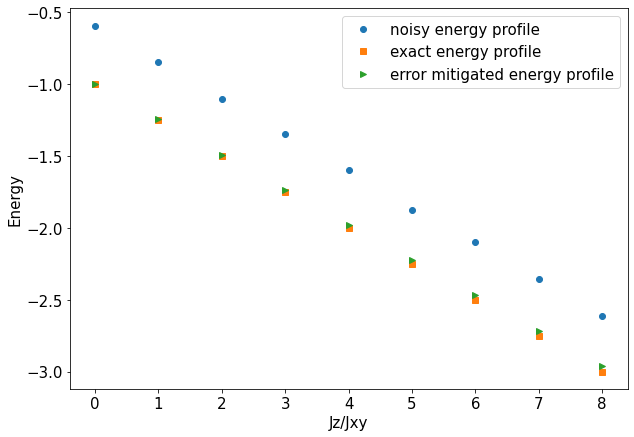

In [167]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.xlabel('Jz/Jxy',fontsize=15)
plt.ylabel('Energy',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(numpy.array(Es_noisy_Arr),marker='o',linestyle='',label='noisy energy profile')
plt.plot(numpy.array(Es_exact_Arr),marker='s',linestyle='',label='exact energy profile')
plt.plot(numpy.array(Es_mitig_Arr),marker='>',linestyle='',label='error mitigated energy profile')
plt.legend(fontsize=15)